Chapter 16

# 正交回归，一元
Book_7《机器学习》 | 鸢尾花书：从加减乘除到机器学习

In [1]:
# single variate TLS regression

# initializations and download results 
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
p = plt.rcParams
p["font.sans-serif"] = ["Roboto"]
p["font.weight"] = "light"
p["ytick.minor.visible"] = True
p["xtick.minor.visible"] = True
p["axes.grid"] = True
p["grid.color"] = "0.5"
p["grid.linewidth"] = 0.5


In [3]:
# y_levels_df = web.get_data_yahoo(['AAPL'], start = '2020-01-01', end = '2020-12-31')

from datetime import datetime
startdate = datetime(2020,1,1)
enddate = datetime(2020,12,31)
y_levels_df = yf.download(tickers = ['AAPL'],
                  start = startdate,
                  end = enddate)

[*********************100%%**********************]  1 of 1 completed


In [4]:
y_levels_df.to_pickle('y_levels_df.pkl')

In [5]:
y_levels_df.round(2).head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,74.06,75.15,73.80,75.09,73.15,135480400
2020-01-03,74.29,75.14,74.12,74.36,72.44,146322800
2020-01-06,73.45,74.99,73.19,74.95,73.02,118387200
2020-01-07,74.96,75.22,74.37,74.60,72.68,108872000
2020-01-08,74.29,76.11,74.29,75.80,73.84,132079200


In [6]:
y_df = y_levels_df['Adj Close'].pct_change()
y_df = y_df.dropna()

In [7]:
# x_levels_df = web.get_data_yahoo(['^GSPC'], start = '2020-01-01', end = '2020-12-31')
x_levels_df = yf.download(tickers = ['^GSPC'],
                  start = startdate,
                  end = enddate)

[*********************100%%**********************]  1 of 1 completed


In [8]:
x_levels_df.round(2).head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,3244.67,3258.14,3235.53,3257.85,3257.85,3459930000
2020-01-03,3226.36,3246.15,3222.34,3234.85,3234.85,3484700000
2020-01-06,3217.55,3246.84,3214.64,3246.28,3246.28,3702460000
2020-01-07,3241.86,3244.91,3232.43,3237.18,3237.18,3435910000
2020-01-08,3238.59,3267.07,3236.67,3253.05,3253.05,3726840000


In [9]:
x_df = x_levels_df['Adj Close'].pct_change()
x_df = x_df.dropna()

In [10]:
# x_df = x_df.rename(columns={"^GSPC": "SP500"})

x_y_df = pd.concat([x_df, y_df], axis=1, join="inner")

In [11]:
#%% USE ODR in SciPy

In [12]:
from scipy.odr import *

# Define a function to fit the data with
def linear_func(b, x):
   b0, b1 = b
   return b1*x + b0

In [13]:
# Create a model for fitting
linear_model = Model(linear_func)

# Load data to the model
data = RealData(x_df.T, y_df.T)

# Set up ODR with the model and data
odr = ODR(data, linear_model, beta0=[0., 1.])

# Solve the regression
out = odr.run()

# Use the in-built pprint method to display results
out.pprint()

#%%

Beta: [0.00164846 1.43712049]
Beta Std Error: [0.00112716 0.05613804]
Beta Covariance: [[ 1.22308641e-02 -2.36574753e-02]
 [-2.36574753e-02  3.03391791e+01]]
Residual Variance: 0.0001038749070840251
Inverse Condition #: 0.22961144322020605
Reason(s) for Halting:
  Sum of squares convergence


In [14]:
y_df.mean()

0.0027690720035688293

In [15]:
#%% TLS, matrix computation
import statsmodels.api as sm

SIMGA = x_y_df.cov()

Lambda, V = np.linalg.eig(SIMGA)

idx = Lambda.argsort()[::-1]   
Lambda = Lambda[idx]
V = V[:,idx]

lambda_min = np.min(Lambda)
b1_TLS = -V[0, 1]/V[1, 1]
print(b1_TLS)

b0_TLS = y_df.mean() - b1_TLS*x_df.mean()
print(b0_TLS)

1.437138320660491
0.0016484446382283927


In [16]:
#%% OLS regression

# add a column of ones
X_df = sm.add_constant(x_df)

model = sm.OLS(y_df, X_df)
results = model.fit()
print(results.summary())

p = model.fit().params

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     550.5
Date:                Tue, 21 Nov 2023   Prob (F-statistic):           5.16e-65
Time:                        20:18:17   Log-Likelihood:                 675.37
No. Observations:                 251   AIC:                            -1347.
Df Residuals:                     249   BIC:                            -1340.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      1.819      0.0

In [17]:
#%% visualization

b0 = out.beta[0]
b1 = out.beta[1]

# generate x-values for  regression line
x_ = np.linspace(x_df.min(),x_df.max(),10)

In [18]:
p

const        0.001893
Adj Close    1.123351
dtype: float64

(-0.15, 0.15)

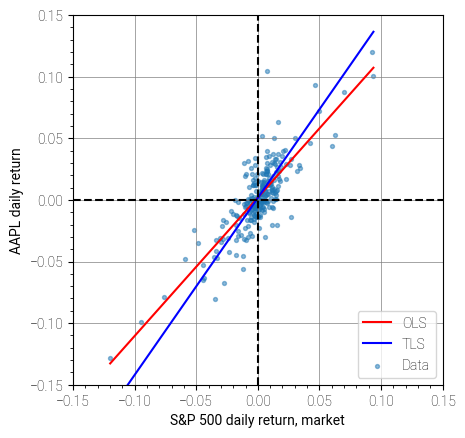

In [19]:
fig, ax = plt.subplots()

# scatter-plot data
plt.scatter(x_df, y_df, alpha = 0.5, 
            s = 8,label = 'Data')

plt.plot(x_, p.const + p['Adj Close'] * x_,
         color = 'r', label = 'OLS')

plt.plot(x_, b0 + b1 * x_,
         color = 'b', label = 'TLS')

plt.axhline(y=0, color='k', linestyle='--')
plt.axvline(x=0, color='k', linestyle='--')
plt.axis('scaled')
plt.legend(loc='lower right')

plt.axis('scaled')
plt.ylabel('AAPL daily return')
plt.xlabel('S&P 500 daily return, market')
plt.xlim([-0.15,0.15])
plt.ylim([-0.15,0.15])